# **Uczenie się ze wzmocnieniem**

Implementacja algorytmu Q-learning oraz stworzenie agenta rozwiązującego problem Taxi. 

Problem dostępny jest w pakieciegym `gym` (`gym.make(’Taxi-v3’)`)

## **Materiały**
 * https://www.gymlibrary.dev/environments/toy_text/taxi/
 * https://web.archive.org/web/20210125043510/http://gym.openai.com/envs/Taxi-v3/

In [14]:
import gym
import numpy as np
import random
from matplotlib import pyplot as plt
from multiprocessing.pool import Pool
import warnings
from functools import partial
import pandas as pd
import seaborn as sns
warnings.filterwarnings("ignore")

## **Q-learning algorytm**

W Q-learningu celem jest nauczenie się polityki, która powie agentowi, jaką akcję powinien podjąć w każdym możliwym stanie. Tablica Q jest odpowiedzialna za przechowywanie wartości score dla każdej pary (stan, akcja). Wartości te mogą być zainicjowane zerami lub losowo, i są one aktualizowane w miarę wykonywania eksploracji w domenie problemu (co pomaga odkryć, które akcje prowadzą do lepszego strumienia nagród).

In [22]:
env = gym.make('Taxi-v3', render_mode='rgb_array').env
env.reset()
env.render()

action_size = env.action_space.n 
print("Action size:", action_size) 

state_size = env.observation_space.n 
print("State size: ", state_size)

Action size: 6
State size:  500


In [9]:
def Qlearning_algorithm(max_steps, gamma, learning_rate, epsilon, episodes, evaluate_every, max_epsilon, min_epsilon, verbose=False):
    '''
    Runs the Q-Learning algorithm and returns the built Q-Table.
    epsilon -- exploration propability
    gamma -- discount factor (later rewards impact less)
    max_steps -- max steps per episode
    episodes -- total episodes
    
    '''
    env = gym.make('Taxi-v3', render_mode='rgb_array').env
    
    state_size = env.observation_space.n
    action_size = env.action_space.n
    q_table = np.zeros((state_size, action_size), dtype=np.float32)
    
    validation_res = {}  # episode -> sum of rewards
    training_res = {}
    
    for episode in range(episodes):
        state, _ = env.reset()
        score = 0
        for step in range(max_steps):
            if np.random.rand() > epsilon:
                # In case of exploitation
                action = np.argmax(q_table[state,:]) 
            else:
                # In case of exploration, explore the action space
                action = np.random.choice(action_size) 
        
            next_state, reward, done, _, _ = env.step(action)
           
            # Update Q-table
            q_table[state, action] = q_table[state, action] + learning_rate * (reward + gamma * 
                                     np.max(q_table[next_state, :]) - q_table[state, action])
            score += reward
            
            # Update state
            state = next_state

            if done == True: 
                break
                
        # Reduce epsilon (because we need less and less exploration)        
        epsilon = min_epsilon + (max_epsilon - min_epsilon) * (1 - (episodes - episode) / episodes)
        training_res[episode] = score
        if episode % evaluate_every == evaluate_every - 1 and verbose:
            validation_score, validation_finished = evaluate(q_table)
            print(f'episode: {episode + 1}, mean score, finished game fraction: {validation_score}, {validation_finished}')
            validation_res[episode] = validation_score
    if verbose:
        plt.plot(validation_res.keys(), validation_res.values())
        plt.legend(['validation'])
        plt.xlabel('Episodes')
        plt.ylabel('Reward')
        plt.show()
    return q_table

In [10]:
def evaluate(q_table, max_steps=100, episodes=10000):
    '''
    Evaluates a Q-Table in a given environment (without exploration), number of 'max_steps' and 'episodes' don't have to be the same as the Q-Learning parameters.
    Returns mean score and finished game fraction.
    '''
    env = gym.make('Taxi-v3', render_mode='rgb_array').env
    scores = []
    finished = []
    for _ in range(episodes):
        state, _ = env.reset()
        score = 0
        for step in range(max_steps):
            action = np.argmax(q_table[state,:]) #Exploatation
            state, reward, done, _, _ = env.step(action)
            score += reward

            if done == True:
                break
        finished.append(done)
        scores.append(score)
    return np.mean(scores), np.mean(finished)

In [11]:
def visualize_epizode(q_table, max_steps=100):
    '''
    Visualization of a single episode.
    '''
    env = gym.make('Taxi-v3', render_mode='rgb_array').env
    
    state, _ = env.reset()
    plt.imshow(env.render())
    plt.show()
    for step in range(max_steps):
        action = np.argmax(q_table[state,:])
        state, reward, done, _, _ = env.step(action)
        plt.imshow(env.render())
        plt.show()

        if done == True: 
            break

episode: 100, mean score, finished game fraction: -129.6185, 0.099
episode: 200, mean score, finished game fraction: -118.6205, 0.3896
episode: 300, mean score, finished game fraction: -58.1336, 0.5722
episode: 400, mean score, finished game fraction: -21.5333, 0.7801
episode: 500, mean score, finished game fraction: -4.8252, 0.8797
episode: 600, mean score, finished game fraction: -1.6311, 0.9095
episode: 700, mean score, finished game fraction: 3.8223, 0.9613
episode: 800, mean score, finished game fraction: 6.5379, 0.9866
episode: 900, mean score, finished game fraction: 6.9669, 0.991
episode: 1000, mean score, finished game fraction: 7.8976, 1.0


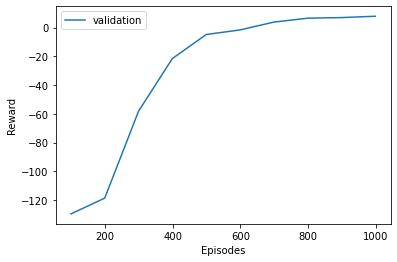

In [33]:
q_table = Qlearning_algorithm(max_steps=1000, gamma=0.9, learning_rate=0.5, epsilon=0.5, episodes=1000, evaluate_every=100, max_epsilon=1, min_epsilon=0.01, verbose=True)

In [32]:
evaluate(q_table)

(7.9187, 1.0)

## **Wnioski**



Wykres przedstawia walidacje treningu modelu wykonywaną, co 100 epizodów.

Wraz z dłuższym czasem trenowania wzrasta nagroda, agent rozwiązuje problem z większą skutecznością. 

## **Wizualizacja pojedyńczego epizodu**

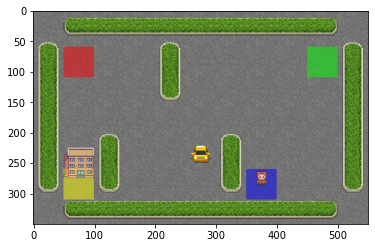

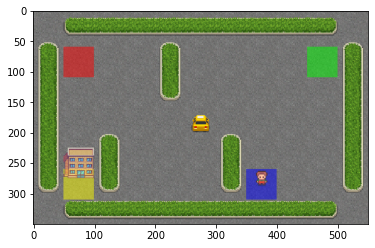

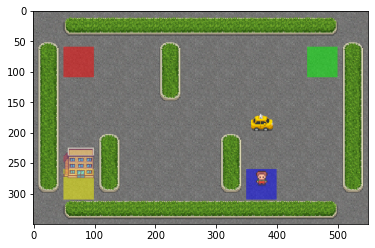

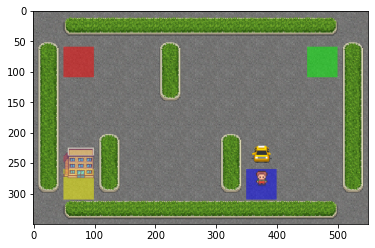

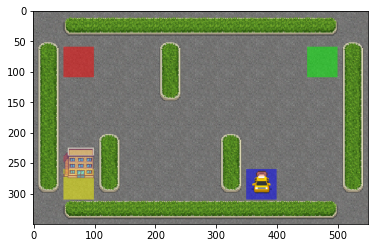

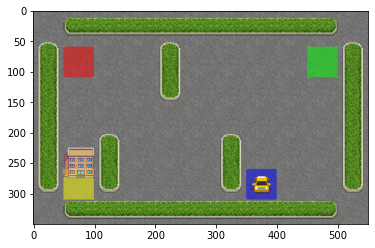

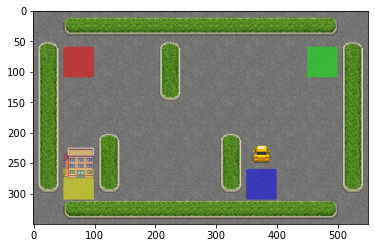

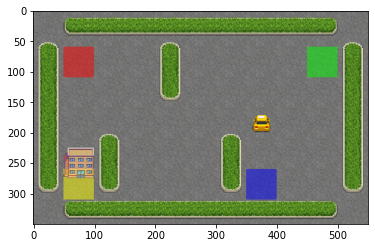

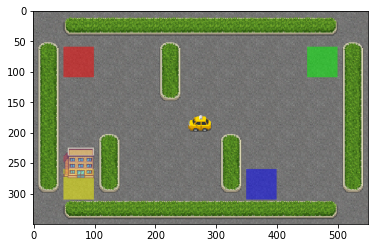

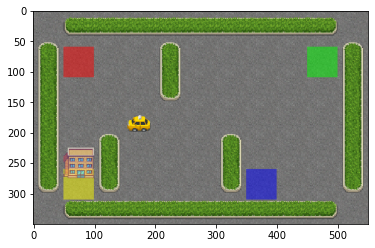

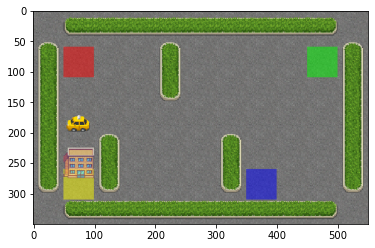

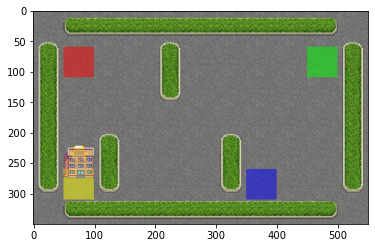

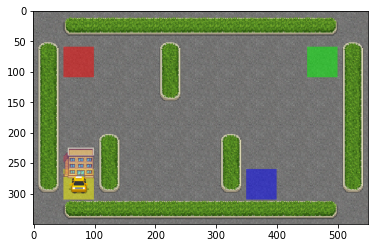

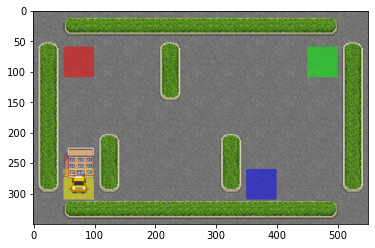

In [8]:
visualize_epizode(q_table)

Poprawne wykonanie algorytmu, odebranie pasażera oraz dostarczenie go do właściwego miejsca. Agent podejmuje najlepsze akcje w tym ustawieniu.

## **Badanie hiperparametrów oraz wykresy**

Wykonywanie eksperymentów na dobranych hiperparametrach `DEFAULT_ARGUMENTS` dla ośmiu powtórzeń treningu za pomocą algorytmu Q-learning.

In [16]:
THREADS = 24
REPS = 8
DEFAULT_ARGUMENTS = {
    'max_steps': 1000,
    'gamma': 0.9,
    'learning_rate': 0.5,
    'epsilon': 0.5,
    'episodes': 2000,
    'evaluate_every': 50,
    'max_epsilon': 1, 
    'min_epsilon': 0.01
}

In [17]:
def qlearning_unpack(args):
    return evaluate(Qlearning_algorithm(**args))[0]

In [18]:
def plot_factor_dependency(name, values, default_arguments, reps=5, xlog=False, pool=__builtins__, show=True):
    res = {name: [], 'score': []}
    for arg in values:
        args = default_arguments.copy()
        args[name] = arg
        
        for r in range(reps):
            res[name].append(arg)
            res['score'].append(pool.apply_async(partial(qlearning_unpack, args)))
            
    res['score'] = [fut.get() for fut in res['score']]
    
    df = pd.DataFrame.from_dict(res) 
    sns.lineplot(data=df, x=name, y='score', errorbar='sd')
    sns.scatterplot(data=df, x=name, y='score', alpha=0.05)
    if xlog:
        plt.xscale('log')
    
    #Rysowanie poziomej najlepszej linii
    aggregated_df = df.groupby(name).mean().reset_index()
    row = aggregated_df[aggregated_df.score == aggregated_df.score.max()].iloc[0]
    plt.axvline(row[name], linestyle='dashed', color='r')
    plt.title(f'{name}\nfound best {name}={row[name]:.2f} with average score {row["score"]:.2f}')
    if show:
        plt.show()

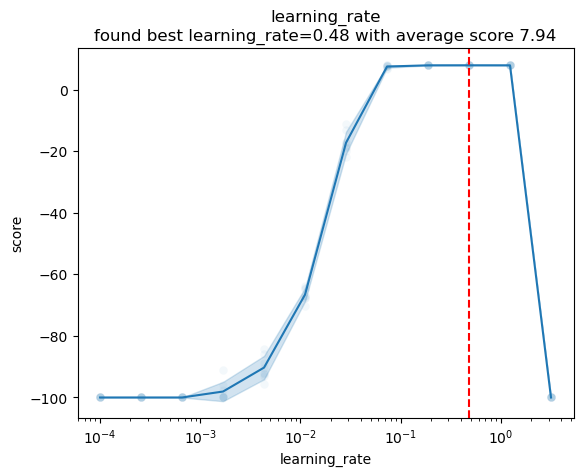

In [63]:
with Pool(THREADS) as pool:
    plot_factor_dependency('learning_rate', np.logspace(-4, 0.5, base=10, num=12), DEFAULT_ARGUMENTS, reps=REPS, pool=pool, xlog=True, show=False)

Dla hiperparametru `learning_rate` przy dobranych hiperparametrach, najlepsza wartość wynosi 0.48. 
Wraz ze wzrostem `learning_rate` model osiąga coraz większe wartości `score` (suma wszystkich nagród w pośrednich stanach), do osiągniecia granicznej wartości, następnie wartośc `score` spada.
Najlepsze uśrednione wartości znajdują sie w granicach od 0.1 do 1 (dla liczby repetycji `reps=8`), model zbiega się.
Dla wartości learning rate większych od 1, model rozbiega się, na podstawie aktualizacji tabeli `q`.

Wykres ma charakter bitoniczny(rośnie-maleje), początkowo learning rate jest za mały, aby sie zbiegnąc, a potem jest za duży i
rozbiega się.

Dla mniejszych wartości `learning_rate` obserujemy większe odchylenie standardowe, z powodu inicjalizacji tabeli q zerami.


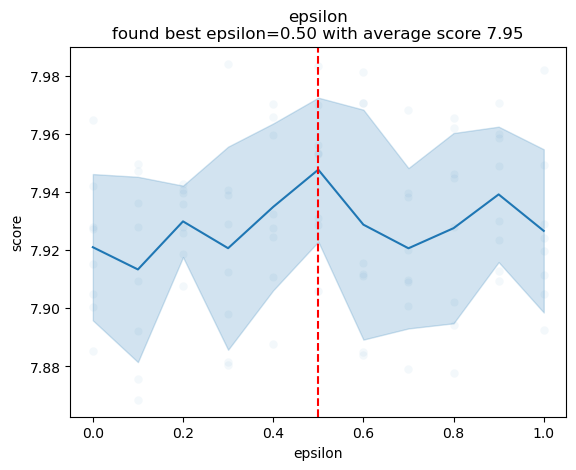

In [64]:
with Pool(THREADS) as pool:
    plot_factor_dependency('epsilon', np.linspace(0, 1, num=11), DEFAULT_ARGUMENTS,reps=REPS, pool=pool, show=False)

Dla hiperparametru `epsilon` (exploration propability) najlepsza wartośc wynosi 0.5, zauważalne jest minimalne odcyhlenie standardowe, wynikające z walidacji wytrenowanego modelu (niedeterminizm wybierania stanu początkowego stanu gry przez biblioteke gym)

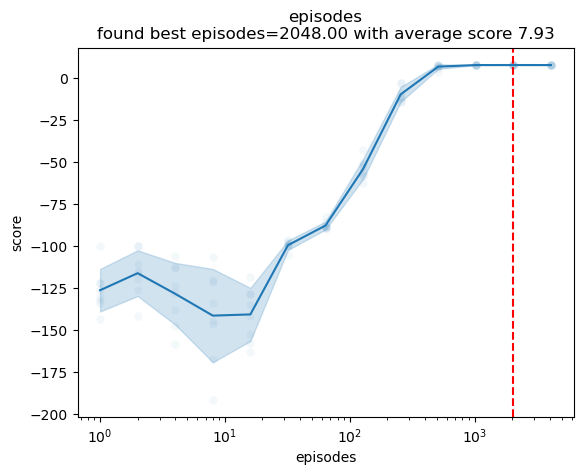

In [60]:
with Pool(THREADS) as pool:
    plot_factor_dependency('episodes', np.logspace(0, 12, base=2, num=13).astype(np.int), DEFAULT_ARGUMENTS, xlog=True, reps=REPS, pool=pool, show=False)

Dla hiperparametru `episodes` najlepsza wartość wynosi 2048. Początkowo wartości `score` maleją oraz występuje większe odchylenie standardowe, następnie od wartości 20 epizodów funkcja rośnie, aż osiąga wartości stałe od wartości 150 epizodów, model stabilizuje się (uśredniony `score` dla 8 repetycji treningu za pomocą algorytmu q-learning).

Im mniejsza liczba epizodów tym większe odchylenie, model nie jest w stanie poprawnie się nauczyć, krótki czas trenowania modelu.
Warto zwrócic uwagę ze duże odchylenie wystepuję do tylok 20 epizodów i learning rate jest dość spory (początkowe gry mają duże znaczenie co do uzyskanego q-table)

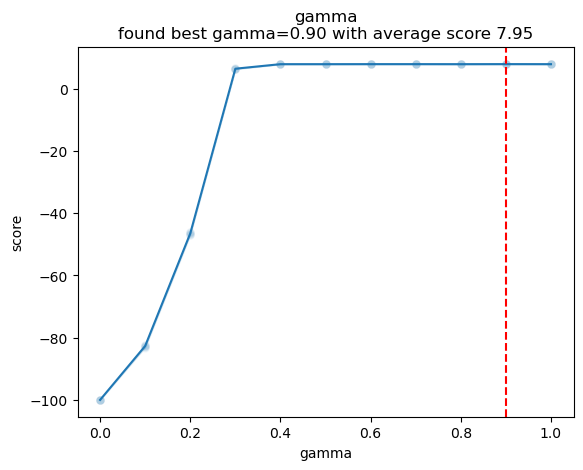

In [65]:
with Pool(THREADS) as pool:
    plot_factor_dependency('gamma', np.linspace(0, 1, num=11), DEFAULT_ARGUMENTS, reps=REPS, pool=pool, show=False)

Dla hiperparametru `gamma` (discount factor) funkcja początkowo rośnie, a pózniej jest stała. Model jest w stanie poprawnie nauczyć się po osiągnieciu wartości gamma równej 0.4 (największa wartośc uśrednionych wartości dla 8 repetycji uczenia się modelu). Spowodowane tym, ze pozytywny reward, mozna tylko dostac raz na samym koncu odstawienia pasazera, wartosc +20. Dla wartości gamma 0.2 i długości gry 14 (długośc zwizualizowanej gry wcześniej narysowanej) po zdyskontowaniu dostajemy impuls równy `0.2^14 * 20 = 3.27e-9` co jest pomijalnie małe (na początku gry model nie ma możliwości zobaczenia optymalnego ruchu z tablicy q-table).

episode: 64, mean score, finished game fraction: -129.4765, 0.0192
episode: 128, mean score, finished game fraction: -119.5388, 0.1663
episode: 192, mean score, finished game fraction: -85.0978, 0.3327
episode: 256, mean score, finished game fraction: -58.2928, 0.4603
episode: 320, mean score, finished game fraction: -63.6473, 0.5756
episode: 384, mean score, finished game fraction: -40.2309, 0.6328
episode: 448, mean score, finished game fraction: -23.0171, 0.7392
episode: 512, mean score, finished game fraction: -15.7883, 0.8076
episode: 576, mean score, finished game fraction: -12.6018, 0.8328
episode: 640, mean score, finished game fraction: -3.4953, 0.8921
episode: 704, mean score, finished game fraction: -1.484, 0.9113
episode: 768, mean score, finished game fraction: 2.0991, 0.9453
episode: 832, mean score, finished game fraction: 3.2649, 0.9562
episode: 896, mean score, finished game fraction: 4.2243, 0.9654
episode: 960, mean score, finished game fraction: 4.8345, 0.9712
episo

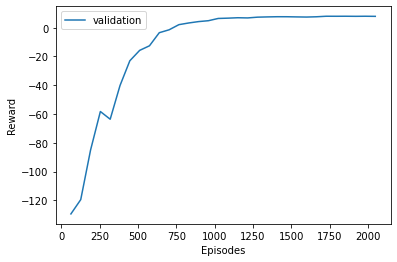

CPU times: user 1min 53s, sys: 288 ms, total: 1min 53s
Wall time: 1min 53s


In [36]:
%%time
q_table = Qlearning_algorithm(max_steps=1000, gamma=0.9, learning_rate=0.48, epsilon=0.5, episodes=2048, evaluate_every=64, max_epsilon=1, min_epsilon=0.01, verbose=True)

In [37]:
%%time
evaluate(q_table)

CPU times: user 1.83 s, sys: 40.1 ms, total: 1.87 s
Wall time: 1.82 s


(7.913, 1.0)

In [42]:
%%time
_ = Qlearning_algorithm(max_steps=1000, gamma=0.9, learning_rate=0.48, epsilon=0.5, episodes=2048, evaluate_every=-1, max_epsilon=1, min_epsilon=0.01, verbose=False)

CPU times: user 5.96 s, sys: 3.98 ms, total: 5.97 s
Wall time: 5.97 s


Trenowanie i walidacja modelu, wykonywana co 64 epizodów dla wybranych nalepszych hiperparametrów zajmuje około 1 min 53s, pojedyńcza walidacja zajmuje 1.82 sekundy, trening zajmuję 5.97 sekund.
Po obliczeniu efektywnie tempo walidacji `10000 / 1.82 = 5495` epizodów na sekundę oraz tempo treningu `2048 / 5.97 = 343` epizodów na sekunde.

Tempo trenowania z walidacja nie sumuje się (1 min 53 sekund jest różne od `1.82 * 32 + 5.97 = 1 min 3 sec`), na gdy model jest niewytrenowany walidacja trwa dłużej, potrzeba więcej kroków na grę, często dochodzi to do ustawionego limitu 100 kroków.

In [51]:
episodes = 2048
evaluate_every = 64
print(episodes/evaluate_every)

32.0
